In [1]:
import scanpy as sc
import pandas as pd
import scvi
from scvi.external import MRVI
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import time

/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
adata = sc.read_h5ad("/home/kassab/Desktop/CB803_project/data/immune_cell_hum.h5ad")

adata.var_names_make_unique()

adata.X = adata.layers["counts"] 
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

filtered_batches = []
batches = adata.obs["batch"].unique()

for batch in batches:
    batch_data = adata[adata.obs["batch"] == batch].copy()

    # Set thresholds dynamically based on distribution
    min_genes_batch = batch_data.obs["n_genes_by_counts"].quantile(0.01)  # Bottom 1% threshold
    max_counts_batch = batch_data.obs["total_counts"].quantile(0.99)  # Top 99% to remove outliers

    print(f"Batch {batch}: Removing cells with <{int(min_genes_batch)} genes and >{int(max_counts_batch)} counts")

    # Apply filtering
    batch_data = batch_data[(batch_data.obs["n_genes_by_counts"] >= min_genes_batch) & 
                            (batch_data.obs["total_counts"] <= max_counts_batch)]
    
    filtered_batches.append(batch_data)

# Merge all batches back together
adata_filtered = sc.concat(filtered_batches, join="inner")

sc.pp.filter_genes(adata, min_cells=3)

sc.pp.scrublet(adata_filtered, batch_key="batch")

adata_filtered.layers["counts"] = np.rint(adata_filtered.layers["counts"]).astype(np.int64)

adata_raw = adata_filtered.copy()

Batch Oetjen_A: Removing cells with <741 genes and >40910 counts
Batch Oetjen_P: Removing cells with <553 genes and >48171 counts
Batch Oetjen_U: Removing cells with <655 genes and >28626 counts
Batch Freytag: Removing cells with <399 genes and >8127 counts
Batch 10X: Removing cells with <902 genes and >19879 counts
Batch Sun_sample1_CS: Removing cells with <465 genes and >11234 counts
Batch Sun_sample2_KC: Removing cells with <447 genes and >9639 counts
Batch Sun_sample3_TB: Removing cells with <466 genes and >9143 counts
Batch Sun_sample4_TC: Removing cells with <440 genes and >9240 counts
Batch Villani: Removing cells with <2664 genes and >893660 counts


In [3]:
import numpy as np
from sklearn.random_projection import GaussianRandomProjection
import scanpy as sc

# Use the raw counts (after filtering and processing)
X = adata_filtered.layers["counts"]

# Optionally normalize/log-transform before projection (depends on your integration pipeline)
# Here’s a quick normalization + log1p if needed:
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
sc.pp.log1p(adata_filtered)

# Use the processed matrix
X = adata_filtered.X

# Define random projection (e.g., 50 components)
rp = GaussianRandomProjection(n_components=50, random_state=42)

# Fit and transform
X_rp = rp.fit_transform(X)

# Save in obsm for downstream analysis (e.g., visualization)
adata_filtered.obsm["X_rp"] = X_rp

mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.941150
CD14+ Monocytes                           0.946609
CD16+ Monocytes                           0.949019
CD20+ B cells                             0.952539
CD4+ T cells                              0.962433
CD8+ T cells                              0.969703
Erythrocytes                              0.970789
Erythroid progenitors                     0.910738
HSPCs                                     0.983277
Megakaryocyte progenitors                 0.959190
Monocyte progenitors                      0.905573
Monocyte-derived dendritic cells          0.953982
NK cells                                  0.966863
NKT cells                                 0.956951
Plasma cells                              0.954467
Plasmacytoid dendritic cells              0.967601


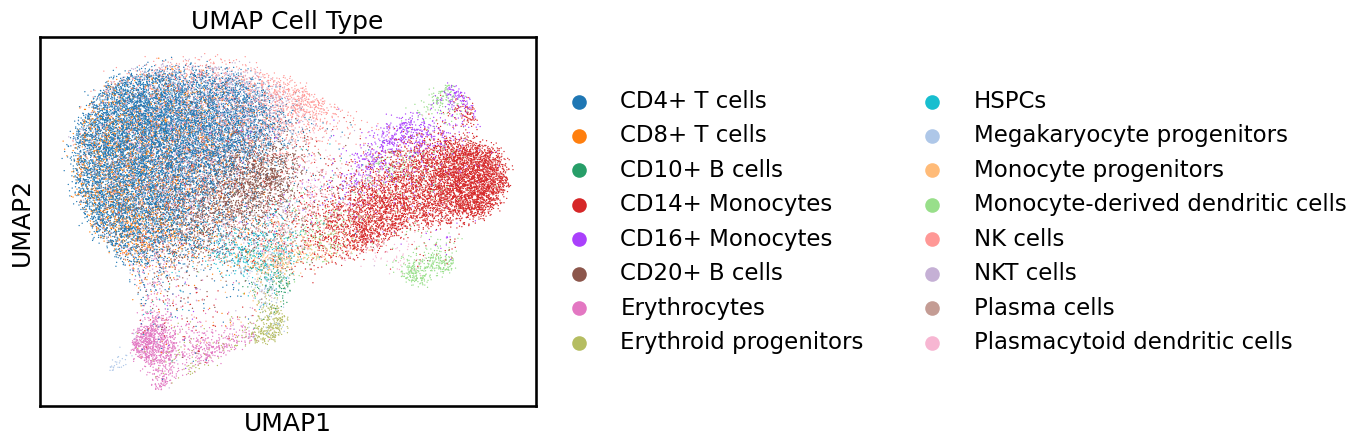

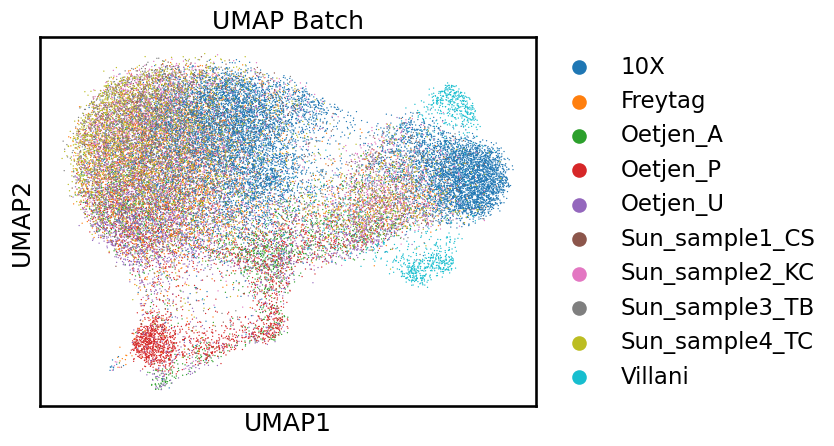

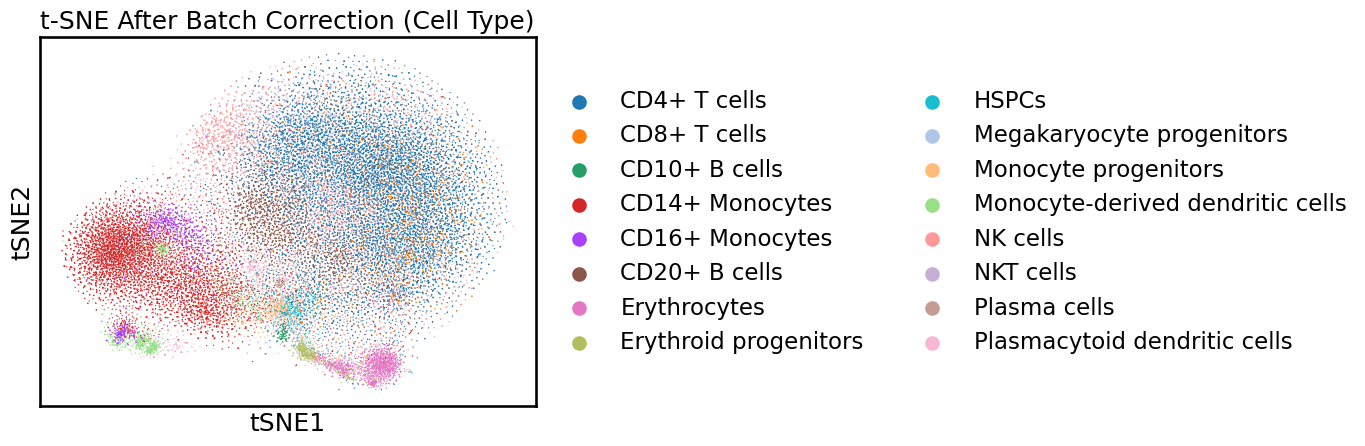

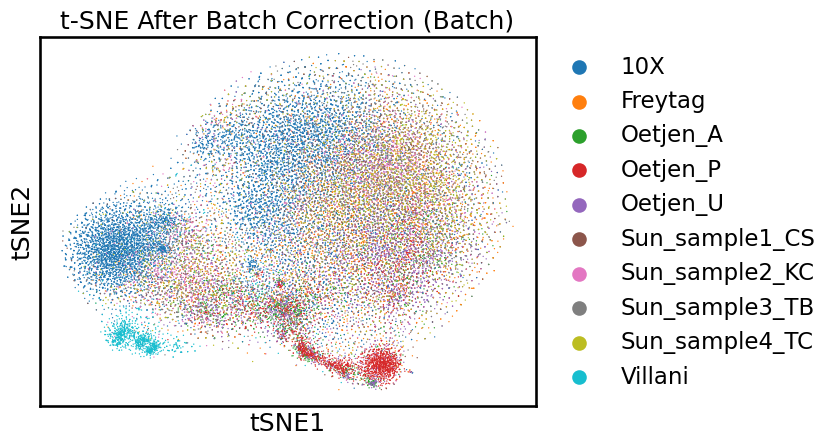

/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)


Cluster for leiden_0.2 with leiden
resolution: 0.2, nmi: 0.4317017357775656
Cluster for leiden_0.4 with leiden
resolution: 0.4, nmi: 0.43733428871115304
Cluster for leiden_0.6 with leiden
resolution: 0.6, nmi: 0.4624209892248203
Cluster for leiden_0.8 with leiden
resolution: 0.8, nmi: 0.4126663202398048
Cluster for leiden_1.0 with leiden
resolution: 1.0, nmi: 0.39970103334458734
Cluster for leiden_1.2 with leiden
resolution: 1.2, nmi: 0.4234582316601682
Cluster for leiden_1.4 with leiden
resolution: 1.4, nmi: 0.40730995022322175
Cluster for leiden_1.6 with leiden
resolution: 1.6, nmi: 0.39874940602322134
Cluster for leiden_1.8 with leiden
resolution: 1.8, nmi: 0.3617520319623699
Cluster for leiden_2.0 with leiden
resolution: 2.0, nmi: 0.3521060222627348
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.4624209892248203


/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:311: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


isolated labels: no more than 3 batches per label
isolated labels: ['CD10+ B cells', 'Erythrocytes', 'Erythroid progenitors', 'Monocyte progenitors']
Cluster for iso_label_0.2 with leiden
resolution: 0.2, max_f1: 0.01692091881465895
Cluster for iso_label_0.4 with leiden
resolution: 0.4, max_f1: 0.016683022571148183
Cluster for iso_label_0.6 with leiden
resolution: 0.6, max_f1: 0.05608380338436744
Cluster for iso_label_0.8 with leiden
resolution: 0.8, max_f1: 0.07611372285650325
Cluster for iso_label_1.0 with leiden
resolution: 1.0, max_f1: 0.07932410232339826
Cluster for iso_label_1.2 with leiden
resolution: 1.2, max_f1: 0.08680020544427323
Cluster for iso_label_1.4 with leiden
resolution: 1.4, max_f1: 0.08774193548387096
Cluster for iso_label_1.6 with leiden
resolution: 1.6, max_f1: 0.1277072442120986
Cluster for iso_label_1.8 with leiden
resolution: 1.8, max_f1: 0.13011863758132414
Cluster for iso_label_2.0 with leiden
resolution: 2.0, max_f1: 0.13333333333333333
optimised clustering

/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:311: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


CD10+ B cells: 0.48213455080986023
Erythrocytes: 0.6221299767494202
Erythroid progenitors: 0.5478687882423401
Monocyte progenitors: 0.48389649391174316


/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/scib/metrics/trajectory.py:120: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  n_components, adata_post.obs["neighborhood"] = connected_components(
/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/scanpy/tools/_dpt.py:25: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm["X_diffmap"] = dpt.eigen_basis
/home/kassab/miniconda3/envs/CB803/lib/python3.12/site-packages/scib/metrics/trajectory.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplac

Batch Correction & Conservation Metrics



Batch correction and biological conservation metrics computed successfully!


In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import scanpy as sc
import scib

# Set model and AnnData object
adata_test = adata_filtered  # Replacing adata_filtered3
#model_test = model  # Replacing model3

# Get latent representation
#latent = model_test.get_latent_representation()
#adata_test.obsm["X_rp"] = latent


# Dictionary to store results
results = {}

# Compute Batch ASW Score
batch_asw = scib.me.silhouette_batch(
    adata_test, batch_key="batch", label_key="cell_type", embed="X_rp", scale=True
)
results["Batch ASW Score"] = batch_asw

# PCA and Neighbors Calculation
sc.tl.pca(adata_test)
sc.pp.neighbors(adata_test, use_rep="X_rp")

# Compute UMAP and Plot
sc.tl.umap(adata_test)
sc.pl.umap(adata_test, color=["cell_type"], frameon=True, title="UMAP Cell Type")
sc.pl.umap(adata_test, color=["batch"], frameon=True, title="UMAP Batch")

# Compute t-SNE and Plot
sc.tl.tsne(adata_test, use_rep="X_rp")
sc.pl.tsne(adata_test, color="cell_type", title="t-SNE After Batch Correction (Cell Type)")
sc.pl.tsne(adata_test, color="batch", title="t-SNE After Batch Correction (Batch)")

# Compute PCR Batch Score
pcr_batch_score = scib.me.pcr_comparison(
    adata_raw,  # Before batch correction
    adata_test,  # After batch correction
    covariate="batch",
    embed="X_rp"
)
results["PCR Batch Score"] = pcr_batch_score

# Compute iLISI Graph Score
ilisi_score = scib.me.ilisi_graph(adata_test, batch_key="batch", type_="embed", use_rep="X_rp")
results["iLISI Score"] = ilisi_score

# Compute Graph Connectivity
graph_connectivity = scib.me.graph_connectivity(adata_test, label_key="cell_type")
results["Graph Connectivity Score"] = graph_connectivity

# Compute NMI (Normalized Mutual Information)
scib.me.cluster_optimal_resolution(adata_test, cluster_key="leiden", label_key="cell_type")
nmi_score = scib.me.nmi(adata_test, cluster_key="leiden", label_key="cell_type")
results["NMI Score"] = nmi_score

# Compute Adjusted Rand Index (ARI)
ari_score = scib.me.ari(adata_test, cluster_key="leiden", label_key="cell_type")
results["ARI Score"] = ari_score

# Compute Label ASW (Silhouette Score)
label_asw = scib.me.silhouette(adata_test, label_key="cell_type", embed="X_rp")
results["Label ASW Score"] = label_asw

# Compute Isolated Label F1 Score
isolated_f1 = scib.me.isolated_labels_f1(adata_test, batch_key="batch", embed=None, label_key="cell_type")
results["Isolated Label F1 Score"] = isolated_f1

# Compute Isolated Label ASW Score
isolated_asw = scib.me.isolated_labels_asw(adata_test, batch_key="batch", label_key="cell_type", embed="X_rp")
results["Isolated Label ASW Score"] = isolated_asw

# Compute cLISI (Cell type Local Inverse Simpson’s Index)
clisi_score = scib.me.clisi_graph(adata_test, label_key="cell_type", type_="embed", use_rep="X_rp")
results["cLISI Score"] = clisi_score

# Compute Trajectory Conservation Score
trajectory_conservation = scib.me.trajectory_conservation(adata_raw, adata_test, label_key="cell_type")
results["Trajectory Conservation Score"] = trajectory_conservation

# Convert results dictionary into a pandas DataFrame
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Score"])

# Display results as a table
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Batch Correction & Conservation Metrics", dataframe=results_df)

print("\nBatch correction and biological conservation metrics computed successfully!")

In [5]:
# Display results as a table
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Batch Correction & Conservation Metrics", dataframe=results_df)

print("\nBatch correction and biological conservation metrics computed successfully!")

Batch Correction & Conservation Metrics



Batch correction and biological conservation metrics computed successfully!


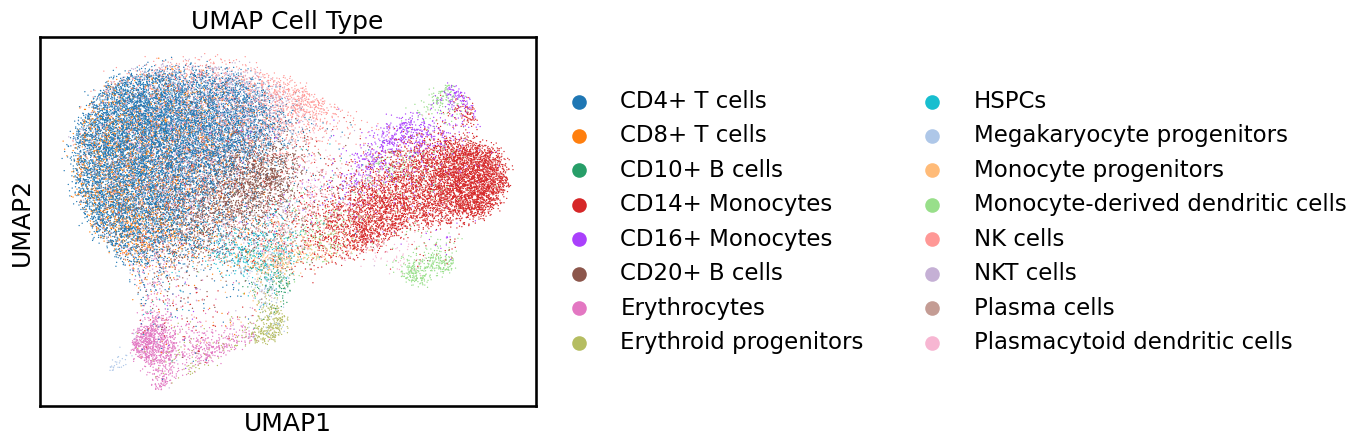

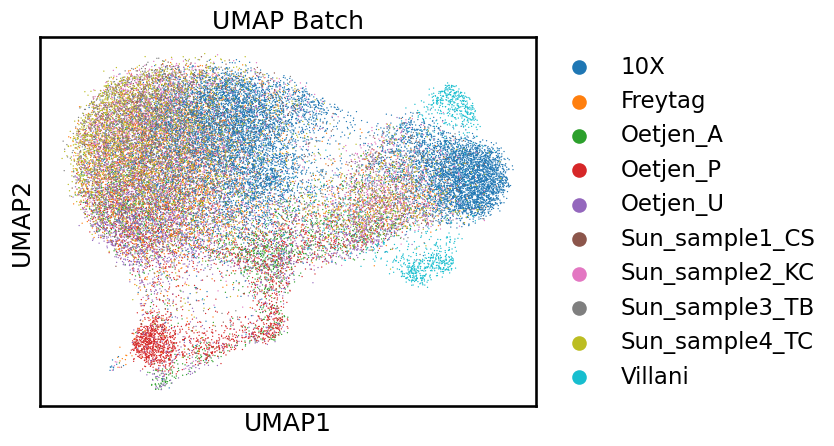

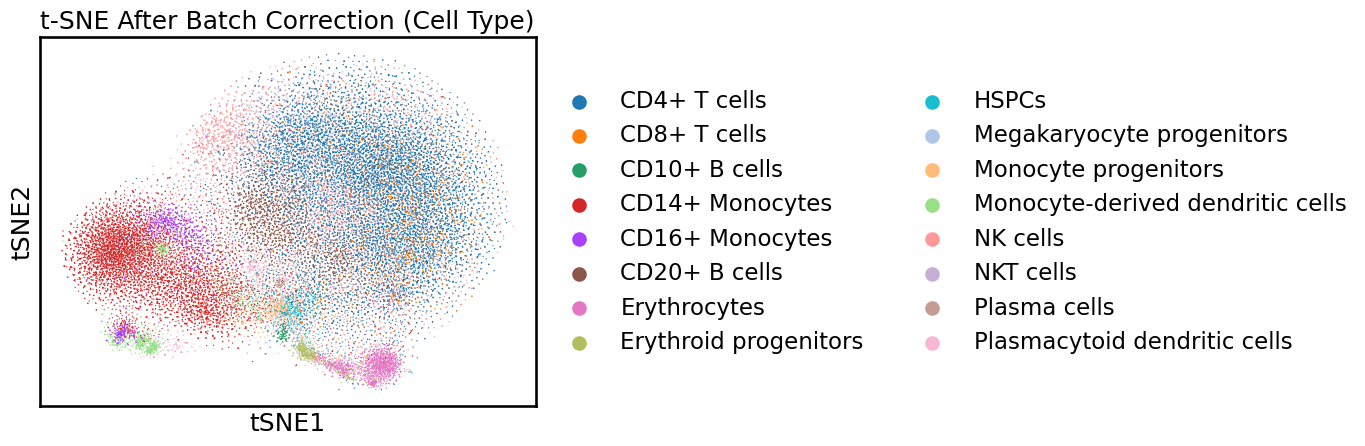

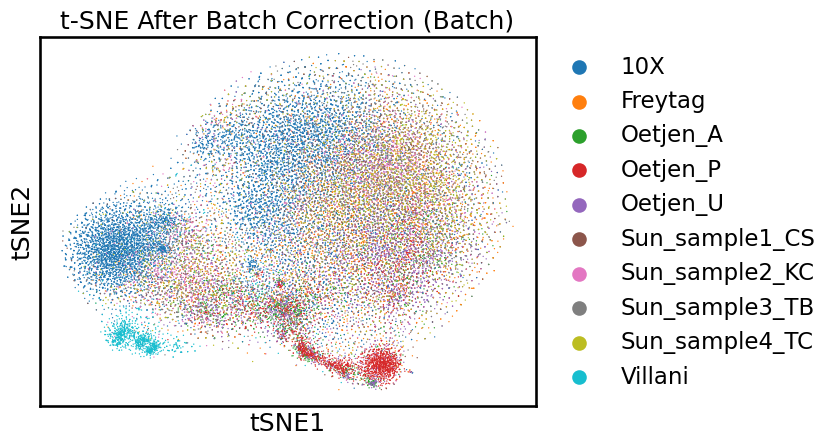

In [6]:
# Compute UMAP and Plot
#sc.tl.umap(adata_test)
sc.pl.umap(adata_test, color=["cell_type"], frameon=True, title="UMAP Cell Type")
sc.pl.umap(adata_test, color=["batch"], frameon=True, title="UMAP Batch")

# Compute t-SNE and Plot
#sc.tl.tsne(adata_test, use_rep="X_mrVI")
sc.pl.tsne(adata_test, color="cell_type", title="t-SNE After Batch Correction (Cell Type)")
sc.pl.tsne(adata_test, color="batch", title="t-SNE After Batch Correction (Batch)")

/tmp/ipykernel_45775/451218646.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_means = X_scVI_emb.groupby(gold_standard.obs["batch"]).mean()


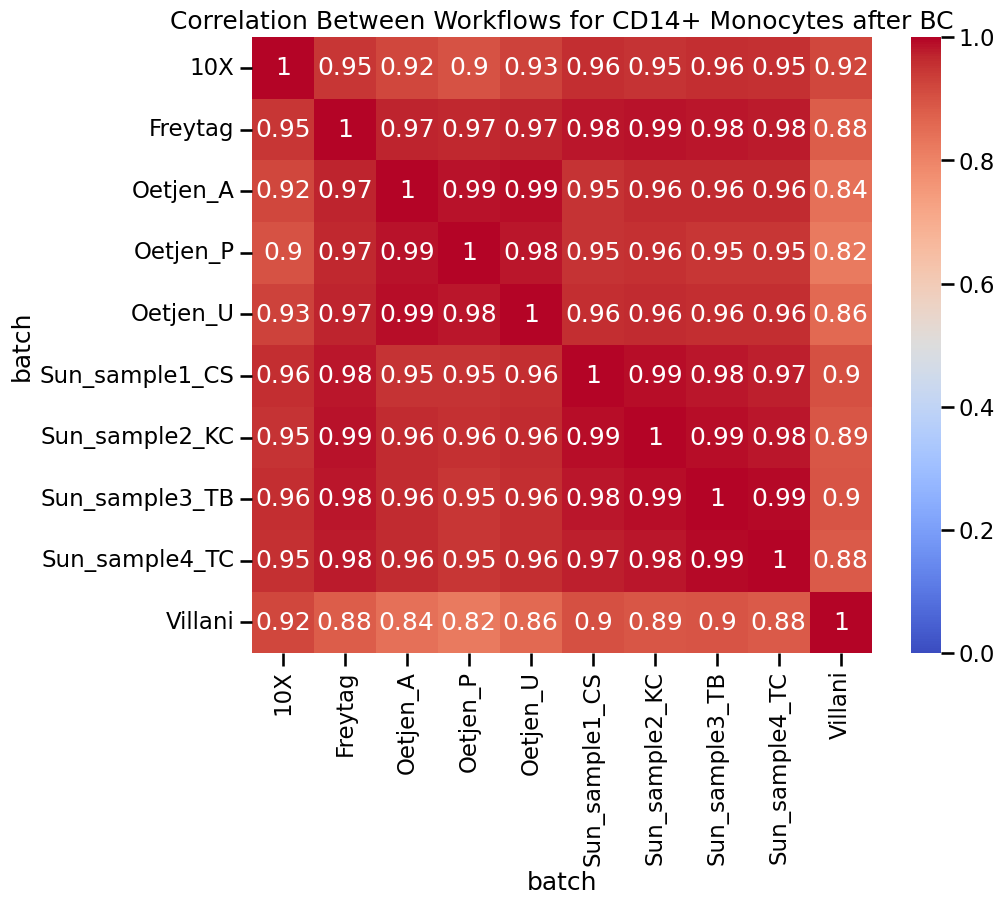

In [8]:
import seaborn as sns
# Select only CD4+ T cells and CD14+ Monocytes from batch-corrected data
gold_standard = adata_test[adata_test.obs["cell_type"].isin(["CD14+ Monocytes"])].copy()

# Extract batch-corrected embeddings from X_scVI
X_scVI_emb = pd.DataFrame(gold_standard.obsm["X_rp"], index=gold_standard.obs.index)

batch_means = X_scVI_emb.groupby(gold_standard.obs["batch"]).mean()

# Compute correlation matrix
corr_matrix = batch_means.T.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Between Workflows for CD14+ Monocytes after BC")
plt.show()

PCA

In [9]:
adata_filtered = adata_raw.copy()

del adata.obsm["X_pca"] 

sc.pp.normalize_total(adata_filtered, target_sum=1e4)

# Step 2: Log1p transform the data
sc.pp.log1p(adata_filtered)

# Step 3: Select highly variable genes (optional but recommended)
sc.pp.highly_variable_genes(adata_filtered, n_top_genes=2000, subset=True)

# Step 4: Scale the data (zero-mean unit-variance per gene)
sc.pp.scale(adata_filtered, max_value=10)

# Step 5: Run PCA
sc.tl.pca(adata_filtered, svd_solver='arpack', n_comps=50)
adata_filtered.obsm["X_pca"]

array([[12.70799    , -1.1247348  , -0.78796226 , ..., -0.097595334,
        -1.0960776  ,  0.59046584 ],
       [-7.991134   ,  0.27152002 , -3.5024343  , ...,  0.13865721 ,
        -0.9190948  ,  0.4164426  ],
       [14.271258   , -2.6315167  , -5.761911   , ..., -2.3196099  ,
        -2.6861668  ,  0.21271887 ],
       ...,
       [28.465916   ,  4.122136   ,  5.745768   , ..., -0.64873046 ,
         0.96998274 , -0.5192464  ],
       [21.775314   ,  3.3480003  ,  7.702384   , ...,  0.82793325 ,
         0.7712369  ,  0.14439158 ],
       [23.59361    ,  5.8491764  ,  8.923761   , ...,  3.2500594  ,
        -0.42752278 ,  3.3024952  ]], dtype=float32)

mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.910492
CD14+ Monocytes                           0.814472
CD16+ Monocytes                           0.821657
CD20+ B cells                             0.885372
CD4+ T cells                              0.900841
CD8+ T cells                              0.868542
Erythrocytes                              0.885376
Erythroid progenitors                     0.874160
HSPCs                                     0.792224
Megakaryocyte progenitors                 0.854244
Monocyte progenitors                      0.882616
Monocyte-derived dendritic cells          0.840573
NK cells                                  0.921218
NKT cells                                 0.885764
Plasma cells                              0.847757
Plasmacytoid dendritic cells              0.669941


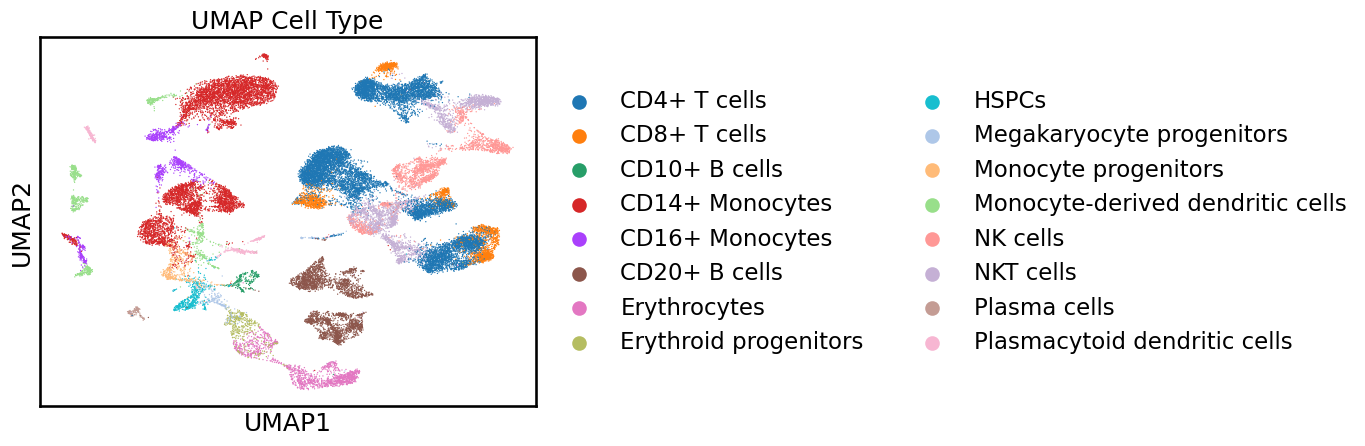

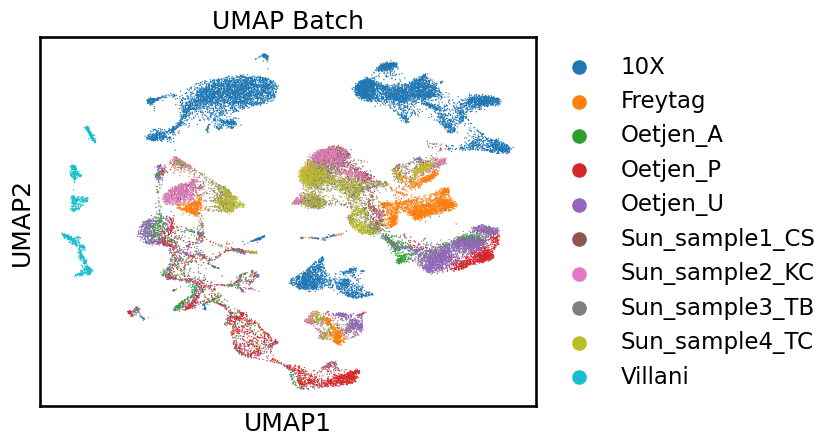

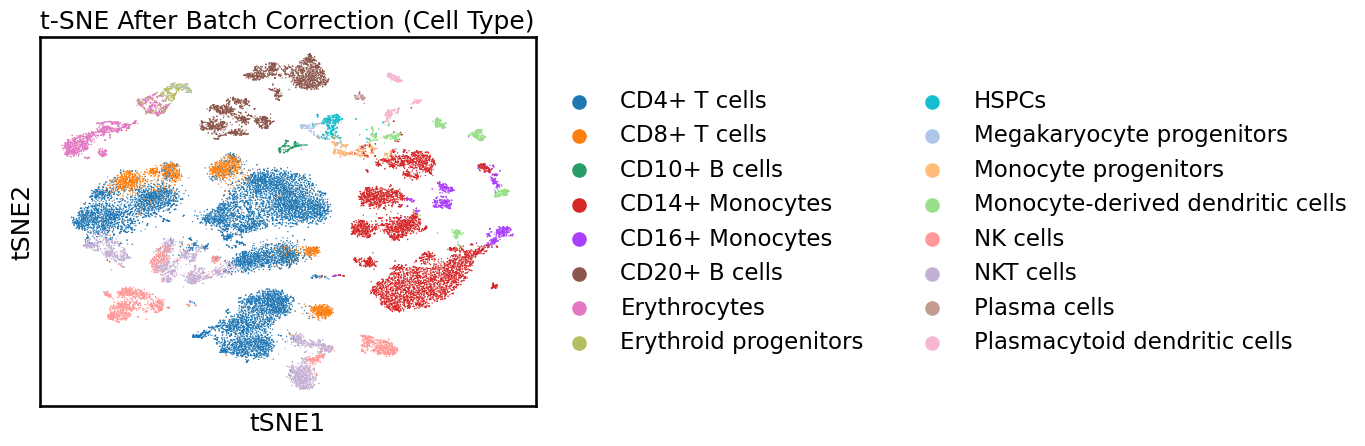

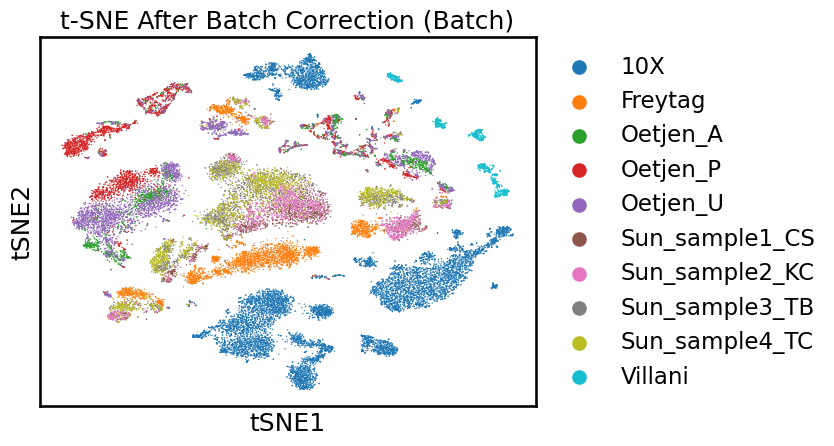

Cluster for leiden_0.2 with leiden
resolution: 0.2, nmi: 0.6365593731038924
Cluster for leiden_0.4 with leiden
resolution: 0.4, nmi: 0.6700349383566375
Cluster for leiden_0.6 with leiden
resolution: 0.6, nmi: 0.6867236240170843
Cluster for leiden_0.8 with leiden
resolution: 0.8, nmi: 0.6738825955557876
Cluster for leiden_1.0 with leiden
resolution: 1.0, nmi: 0.662946418493776
Cluster for leiden_1.2 with leiden
resolution: 1.2, nmi: 0.6692634982778604
Cluster for leiden_1.4 with leiden
resolution: 1.4, nmi: 0.6664135884716315
Cluster for leiden_1.6 with leiden
resolution: 1.6, nmi: 0.6532996157802151
Cluster for leiden_1.8 with leiden
resolution: 1.8, nmi: 0.6549354756993312
Cluster for leiden_2.0 with leiden
resolution: 2.0, nmi: 0.6443964332488821
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.6867236240170843
isolated labels: no more than 3 batches per label
isolated labels: ['CD10+ B cells', 'Erythrocytes', 'Erythroid progenitors', 'Monocyte 


Batch correction and biological conservation metrics computed successfully!


In [10]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import scanpy as sc
import scib

# Set model and AnnData object
adata_test = adata_filtered  # Replacing adata_filtered3
#model_test = model  # Replacing model3

# Get latent representation
#latent = model_test.get_latent_representation()
#adata_test.obsm["X_rp"] = latent


# Dictionary to store results
results = {}

# Compute Batch ASW Score
batch_asw = scib.me.silhouette_batch(
    adata_test, batch_key="batch", label_key="cell_type", embed="X_pca", scale=True
)
results["Batch ASW Score"] = batch_asw

# PCA and Neighbors Calculation
sc.tl.pca(adata_test)
sc.pp.neighbors(adata_test, use_rep="X_pca")

# Compute UMAP and Plot
sc.tl.umap(adata_test)
sc.pl.umap(adata_test, color=["cell_type"], frameon=True, title="UMAP Cell Type")
sc.pl.umap(adata_test, color=["batch"], frameon=True, title="UMAP Batch")

# Compute t-SNE and Plot
sc.tl.tsne(adata_test, use_rep="X_pca")
sc.pl.tsne(adata_test, color="cell_type", title="t-SNE After Batch Correction (Cell Type)")
sc.pl.tsne(adata_test, color="batch", title="t-SNE After Batch Correction (Batch)")

# Compute PCR Batch Score
pcr_batch_score = scib.me.pcr_comparison(
    adata_raw,  # Before batch correction
    adata_test,  # After batch correction
    covariate="batch",
    embed="X_pca"
)
results["PCR Batch Score"] = pcr_batch_score

# Compute iLISI Graph Score
ilisi_score = scib.me.ilisi_graph(adata_test, batch_key="batch", type_="embed", use_rep="X_pca")
results["iLISI Score"] = ilisi_score

# Compute Graph Connectivity
graph_connectivity = scib.me.graph_connectivity(adata_test, label_key="cell_type")
results["Graph Connectivity Score"] = graph_connectivity

# Compute NMI (Normalized Mutual Information)
scib.me.cluster_optimal_resolution(adata_test, cluster_key="leiden", label_key="cell_type")
nmi_score = scib.me.nmi(adata_test, cluster_key="leiden", label_key="cell_type")
results["NMI Score"] = nmi_score

# Compute Adjusted Rand Index (ARI)
ari_score = scib.me.ari(adata_test, cluster_key="leiden", label_key="cell_type")
results["ARI Score"] = ari_score

# Compute Label ASW (Silhouette Score)
label_asw = scib.me.silhouette(adata_test, label_key="cell_type", embed="X_pca")
results["Label ASW Score"] = label_asw

# Compute Isolated Label F1 Score
isolated_f1 = scib.me.isolated_labels_f1(adata_test, batch_key="batch", embed=None, label_key="cell_type")
results["Isolated Label F1 Score"] = isolated_f1

# Compute Isolated Label ASW Score
isolated_asw = scib.me.isolated_labels_asw(adata_test, batch_key="batch", label_key="cell_type", embed="X_pca")
results["Isolated Label ASW Score"] = isolated_asw

# Compute cLISI (Cell type Local Inverse Simpson’s Index)
clisi_score = scib.me.clisi_graph(adata_test, label_key="cell_type", type_="embed", use_rep="X_pca")
results["cLISI Score"] = clisi_score

# Compute Trajectory Conservation Score
trajectory_conservation = scib.me.trajectory_conservation(adata_raw, adata_test, label_key="cell_type")
results["Trajectory Conservation Score"] = trajectory_conservation

# Convert results dictionary into a pandas DataFrame
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Score"])

# Display results as a table
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Batch Correction & Conservation Metrics", dataframe=results_df)

print("\nBatch correction and biological conservation metrics computed successfully!")

In [11]:
# Display results as a table
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Batch Correction & Conservation Metrics", dataframe=results_df)

print("\nBatch correction and biological conservation metrics computed successfully!")

Batch Correction & Conservation Metrics



Batch correction and biological conservation metrics computed successfully!


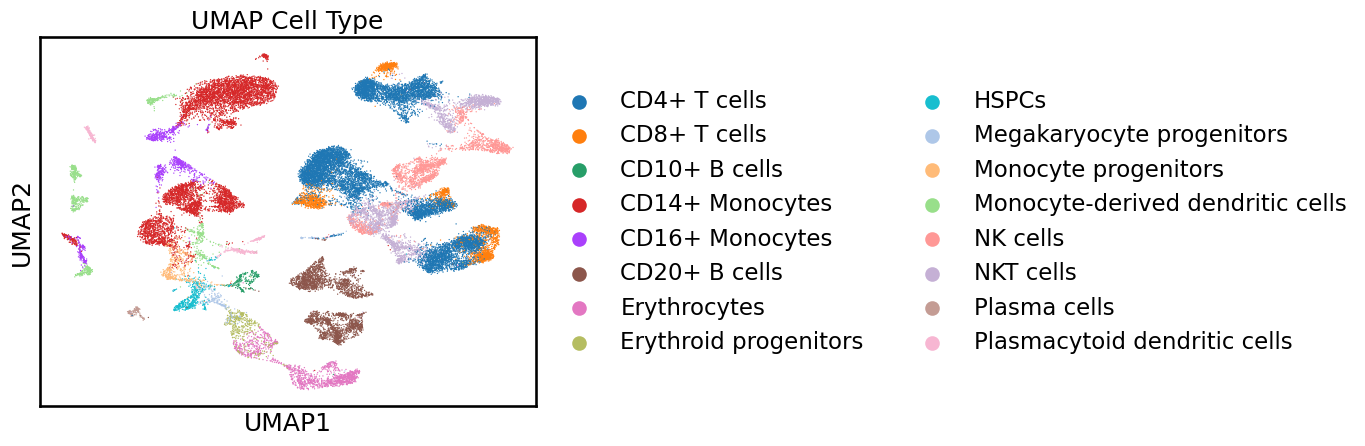

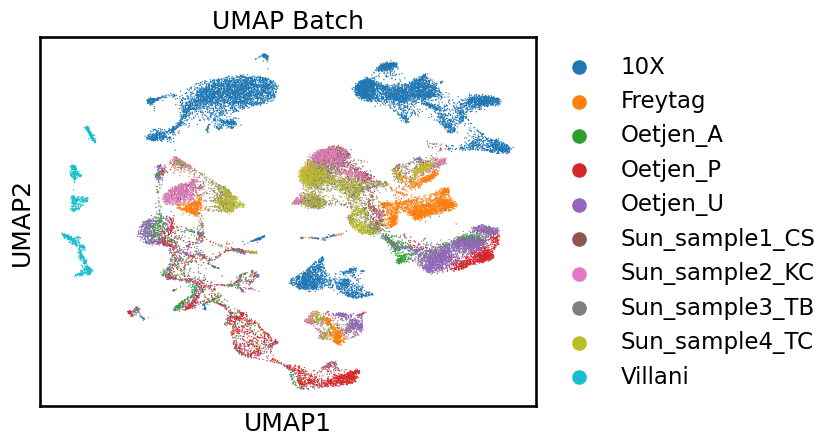

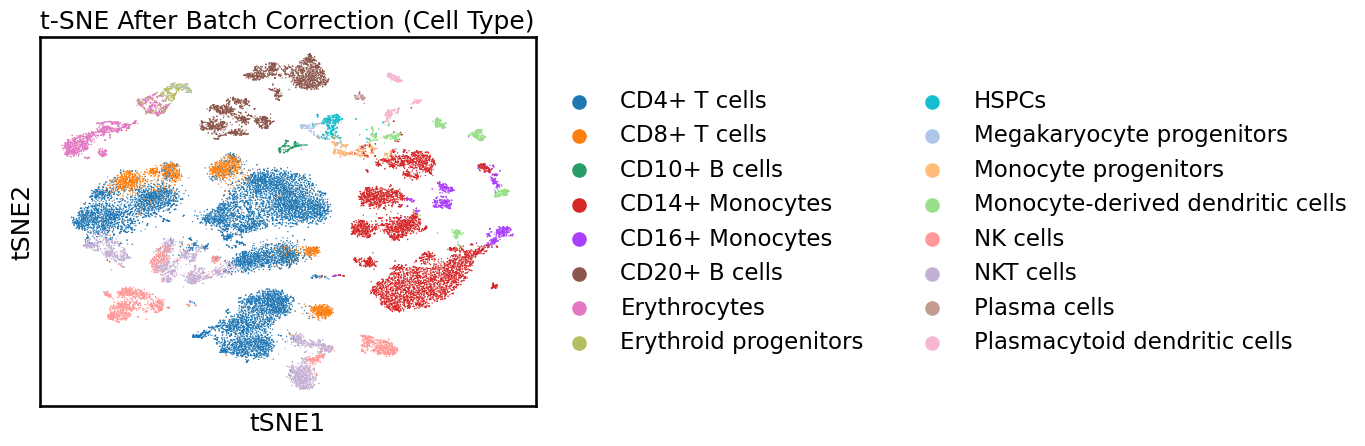

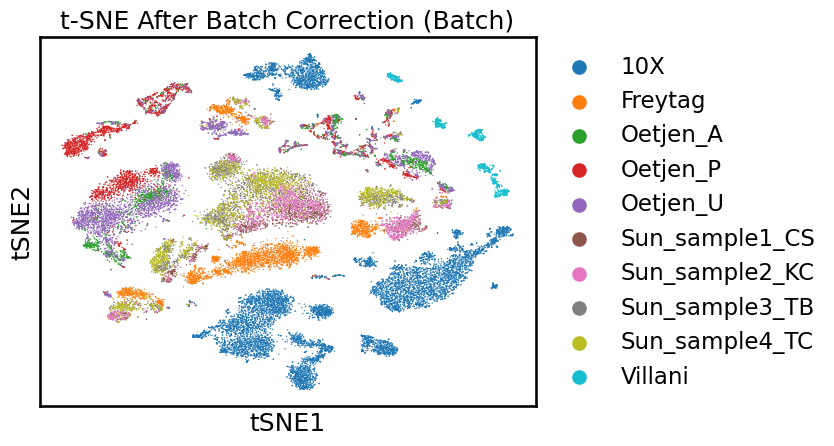

In [12]:
# Compute UMAP and Plot
#sc.tl.umap(adata_test)
sc.pl.umap(adata_test, color=["cell_type"], frameon=True, title="UMAP Cell Type")
sc.pl.umap(adata_test, color=["batch"], frameon=True, title="UMAP Batch")

# Compute t-SNE and Plot
#sc.tl.tsne(adata_test, use_rep="X_mrVI")
sc.pl.tsne(adata_test, color="cell_type", title="t-SNE After Batch Correction (Cell Type)")
sc.pl.tsne(adata_test, color="batch", title="t-SNE After Batch Correction (Batch)")

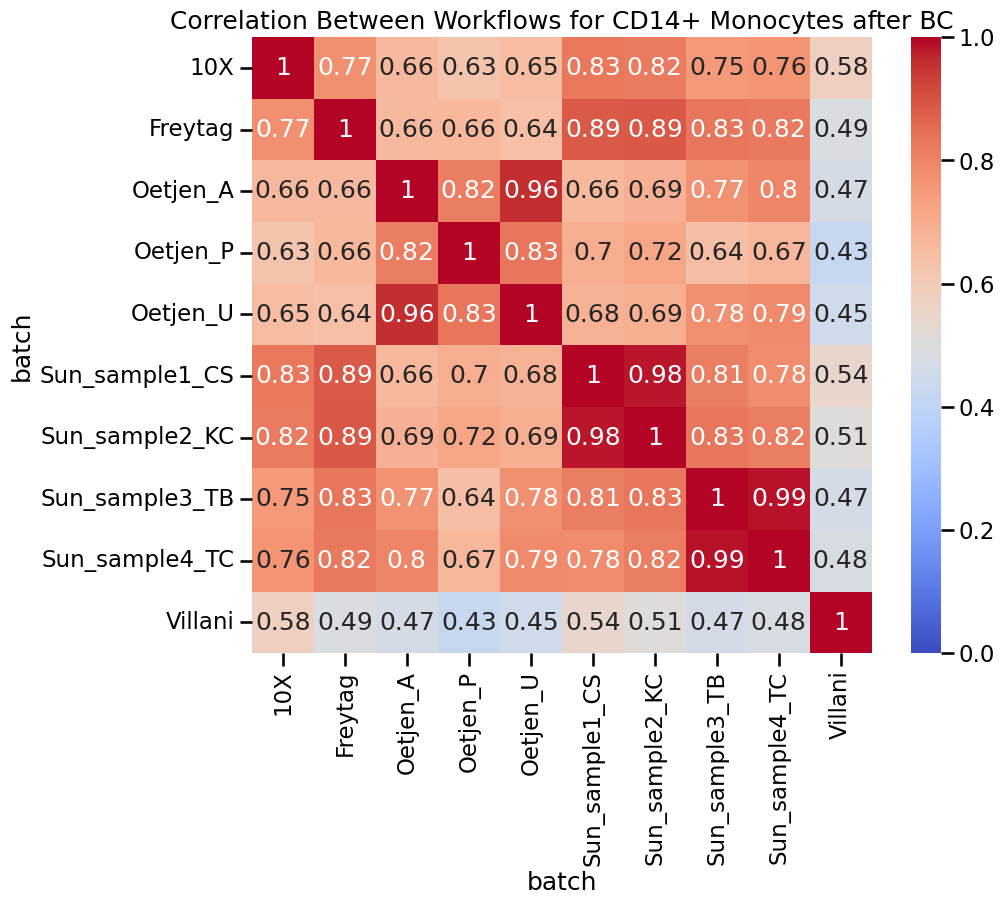

In [13]:
import seaborn as sns
# Select only CD4+ T cells and CD14+ Monocytes from batch-corrected data
gold_standard = adata_test[adata_test.obs["cell_type"].isin(["CD14+ Monocytes"])].copy()

# Extract batch-corrected embeddings from X_scVI
X_scVI_emb = pd.DataFrame(gold_standard.obsm["X_pca"], index=gold_standard.obs.index)

batch_means = X_scVI_emb.groupby(gold_standard.obs["batch"]).mean()

# Compute correlation matrix
corr_matrix = batch_means.T.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation Between Workflows for CD14+ Monocytes after BC")
plt.show()